# Проект по Методи и софтуер за машинно обучение
Студент: Кристиян Кръчмаров <br>
Фак. номер: 791324005 <br>


## Зареждане на данните

In [1]:
import keras
import pandas as pd

path = "../Data/"
data = pd.read_csv(path + "shuffle_email_spam_classification.csv")
data.info()
print("\nNaN in data: {}".format(data.isna().any().any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB

NaN in data: False


In [2]:
data = data.iloc[:, 1:]  # remove 'Email No' column

X = data.iloc[:, :-1]  # explanatory variables
Y = data.iloc[:, -1]  # result

print(X.shape)
print(Y.shape)

(5172, 3000)
(5172,)


## Helpers
Няколко helper метода за улеснение <br>

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone
import matplotlib.pyplot as plt


def get_metrics(classifier, x_train, y_train, x_test, y_test):
    """Train a classifier and get different metrics"""

    classifier = clone(classifier) # get unfitted classifier
    classifier.fit(x_train, y_train) # train

    predicted = classifier.predict(x_test) # get prediction
    probabilities = classifier.predict_proba(x_test) # get probabilities of each class
    probabilities = probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probabilities) # ROC curve
    auc = roc_auc_score(y_test, probabilities) # AUC score

    conf_matrix = confusion_matrix(y_test, predicted) # confusion matrix

    accuracy = classification_report(y_test, predicted, output_dict=True)['accuracy'] # accuracy
    cl_report = classification_report(y_test, predicted, output_dict=False) # classification report

    return {
        "ACC": accuracy,
        "AUC": auc,
        "TPR": tpr,
        "FPR": fpr,
        "Threshold": threshold,
        "ConfusionMatrix": conf_matrix,
        "ClassificationReport": cl_report,
    }


In [4]:
def get_metrics_train_and_test(classifier, X_train, Y_train, X_test, Y_test, plot_roc_curve=False):
    """
    Get metrics for a classifier when training and test data are the same and also train and test data are different.
    Plot the ROC curve.
    Return the metrics for each training scenario
    """
    train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
    train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

    # Plot set up
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(20, 8))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].set_title("ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].set_title("ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

        axes[0].plot(train_test["FPR"], train_test["TPR"], marker="", color="green", alpha=0.6)
        axes[1].plot(train_train["FPR"], train_train["TPR"], marker="", color="red", alpha=0.6)

        plt.show()


    return {
        "train-train": train_train,
        "train-test": train_test,
    }

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold

def k_fold_validation(classifier, X: pd.DataFrame, Y: pd.DataFrame, splits=10, plot_roc_curve=False):
    """
    Perform k-fold cross validation for classifier.
    Plot the ROC curve for each fold.
    Return the performance metrics for each fold.
    """

    # kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    performance_df = pd.DataFrame(columns=["Fold", "ACC Test", "ACC Training", "ACC ratio", "AUC Test", "AUC Training", "AUC ratio", "CONF_MTX"])

    # plot set up
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(20, 8))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].title.set_text("k-Fold ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].title.set_text("k-Fold ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")


    i = 0
    #k-fold
    for trainIndex, testIndex in kf.split(X, Y):
        print(f"Processing fold {i + 1}...")
        X_train, X_test = X.iloc[trainIndex], X.iloc[testIndex]
        Y_train, Y_test = Y.iloc[trainIndex], Y.iloc[testIndex]


        metrics_train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
        metrics_train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

        if plot_roc_curve:
            axes[0].plot(metrics_train_test["FPR"], metrics_train_test["TPR"], marker="", color="blue", alpha=0.6)
            axes[1].plot(metrics_train_train["FPR"], metrics_train_train["TPR"], marker="", color="orange", alpha=0.6)

        temp = {'Fold': i,
                'ACC Test': metrics_train_test["ACC"],
                'ACC Training': metrics_train_train["ACC"],
                'ACC ratio': metrics_train_test["ACC"] / metrics_train_train["ACC"],
                'AUC Test': metrics_train_test["AUC"],
                'AUC Training': metrics_train_train["AUC"],
                'AUC ratio': metrics_train_test["AUC"] / metrics_train_train["AUC"],
                'CONF_MTX': metrics_train_test["ConfusionMatrix"]}

        temp_df = pd.DataFrame([temp])
        performance_df = pd.concat([performance_df, temp_df], ignore_index=True)
        i=i+1

    if plot_roc_curve:
        plt.show()

    return performance_df

In [6]:
def print_metrics(metrics_train_and_test):
    """Print metrics for differently trained classifier"""
    train_train = metrics_train_and_test.get('train-train', 'not-found')
    train_test = metrics_train_and_test.get('train-test', 'not-found')

    print("Train-Train AUC: {}".format(train_train.get('AUC', 'not-found')))
    print("Train-Test AUC: {}".format(train_test.get('AUC', 'not-found')))
    print("\n")
    print("Train-Train ACC: {}".format(train_train.get('ACC', 'not-found')))
    print("Train-Test ACC: {}".format(train_test.get('ACC', 'not-found')))
    print("\n")
    print("Train-Train Confusion Matrix: \n {}".format(train_train.get('ConfusionMatrix', 'not-found')))
    print("\n")
    print("Train-Test Confusion Matrix: \n {}".format(train_test.get('ConfusionMatrix', 'not-found')))
    print("\n")
    print("Train-Train Classification report: \n {}".format(train_train.get('ClassificationReport', 'not-found')))
    print("\n")
    print("Train-Test Classification report: \n {}".format(train_test.get('ClassificationReport', 'not-found')))


In [7]:
def plot_history_nn(nn):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(nn.history['accuracy'], color='blue')
    ax[0].plot(nn.history['val_accuracy'], color='green')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Test'])
    ax[0].axis(ymin=0.5, ymax=1.0)
    ax[0].margins(0.03)

    ax[1].plot(nn.history['loss'])
    ax[1].plot(nn.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Test'])
    ax[1].margins(0.03)

    plt.show()

## 1. Logistic regression
Първо ще обучим една логистична регресия без preprocessing за да видим как се справя

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # random_state so that every run the data splits are the same (for simplicity)
print(X_train.shape,Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


C:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


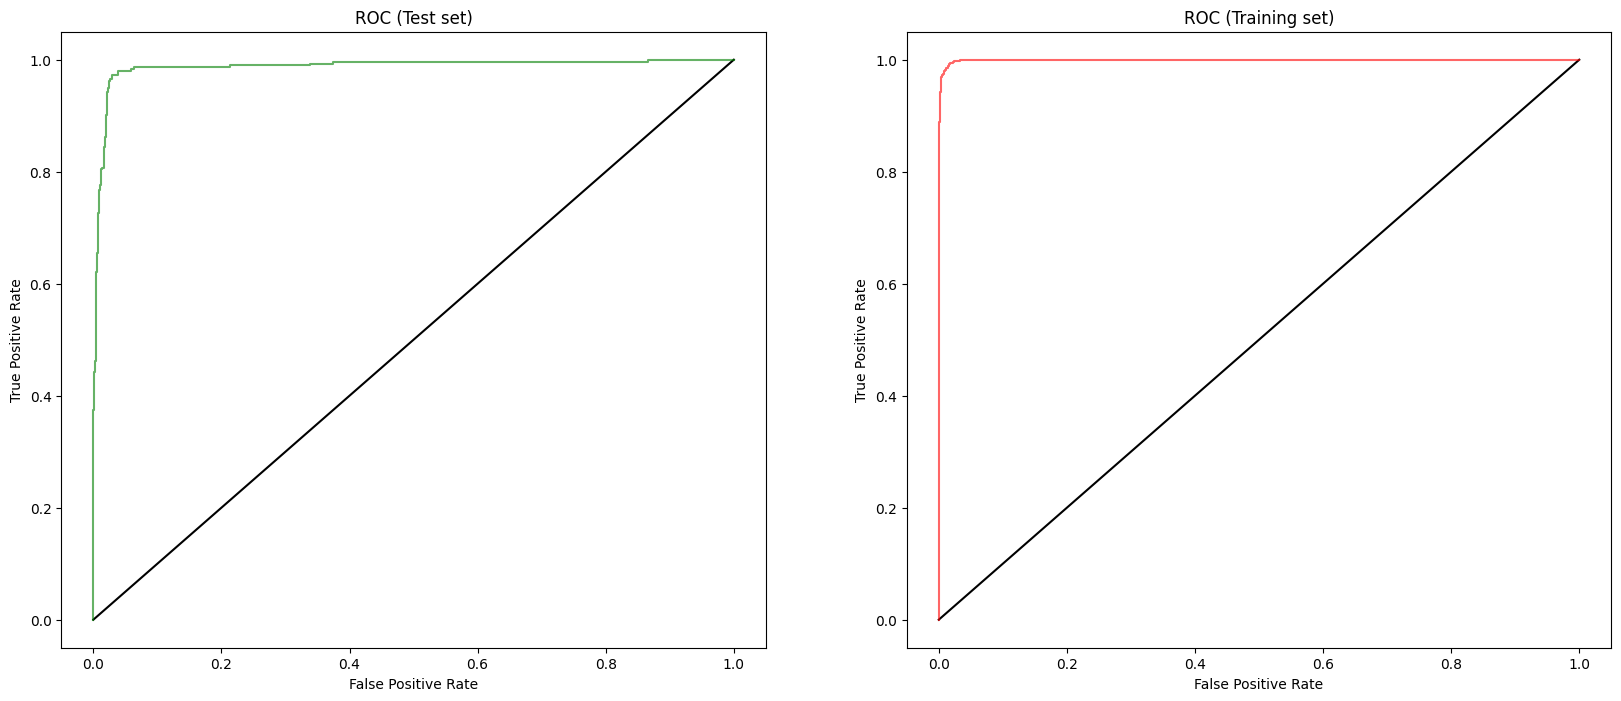

In [9]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


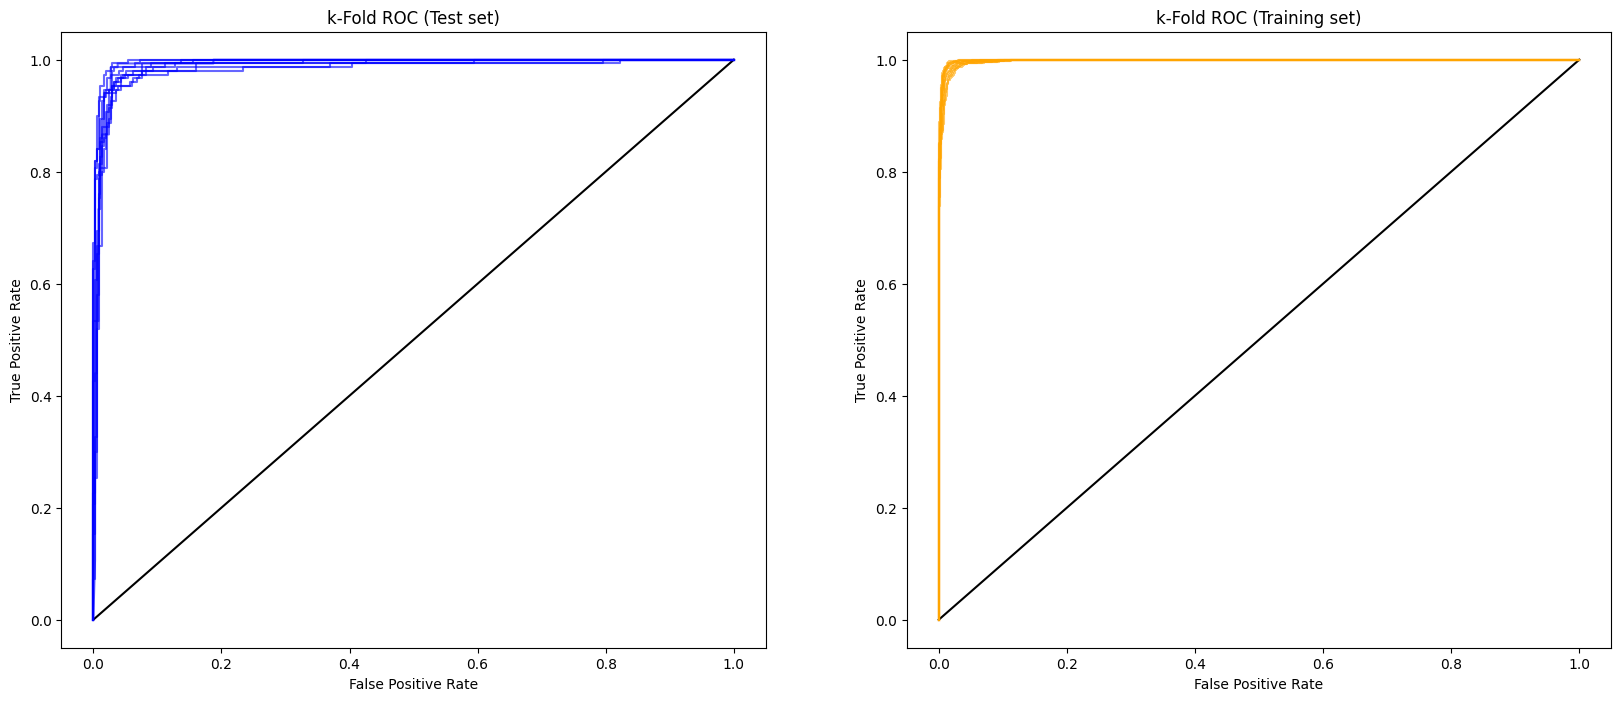

,Fold,ACC Test,ACC Training,ACC ratio,AUC Test,AUC Training,AUC ratio,CONF_MTX
0,0,0.963320,0.983885,0.979099,0.988605,0.998597,0.989994,"[[357, 11], [8, 142]]"
1,1,0.971042,0.989042,0.981801,0.990707,0.999280,0.991421,"[[358, 10], [5, 145]]"
2,2,0.969052,0.987325,0.981492,0.989137,0.999004,0.990124,"[[362, 5], [11, 139]]"
3,3,0.980658,0.978303,1.002407,0.997348,0.997320,1.000028,"[[361, 6], [4, 146]]"
4,4,0.955513,0.980021,0.974991,0.985431,0.997444,0.987957,"[[355, 12], [11, 139]]"
5,5,0.961315,0.980666,0.980268,0.994314,0.997952,0.996355,"[[356, 11], [9, 141]]"
6,6,0.970986,0.986466,0.984308,0.989900,0.998792,0.991097,"[[355, 12], [3, 147]]"
7,7,0.970986,0.984533,0.986241,0.988847,0.998267,0.990563,"[[360, 7], [8, 142]]"
8,8,0.961315,0.988400,0.972598,0.990899,0.999275,0.991618,"[[353, 14], [6, 144]]"
9,9,0.959381,0.986037,0.972967,0.985413,0.998956,0.986443,"[[356, 11], [10, 140]]"


In [10]:
import warnings # to not log the same warning on every iteration

warnings.filterwarnings('ignore')
lr_k_fold = k_fold_validation(logistic_regression, X, Y, plot_roc_curve=True)
warnings.filterwarnings('default')

lr_k_fold.head(10)

In [11]:
print_metrics(lr_metrics_train_and_test)

Train-Train AUC: 0.9993217856604816
Train-Test AUC: 0.9876248034231796


Train-Train ACC: 0.9869470630891951
Train-Test ACC: 0.9710144927536232


Train-Train Confusion Matrix: 
 [[2898   35]
 [  19 1185]]


Train-Test Confusion Matrix: 
 [[719  20]
 [ 10 286]]


Train-Train Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2933
           1       0.97      0.98      0.98      1204

    accuracy                           0.99      4137
   macro avg       0.98      0.99      0.98      4137
weighted avg       0.99      0.99      0.99      4137



Train-Test Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       739
           1       0.93      0.97      0.95       296

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



Сега с `Normalizer`

In [12]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


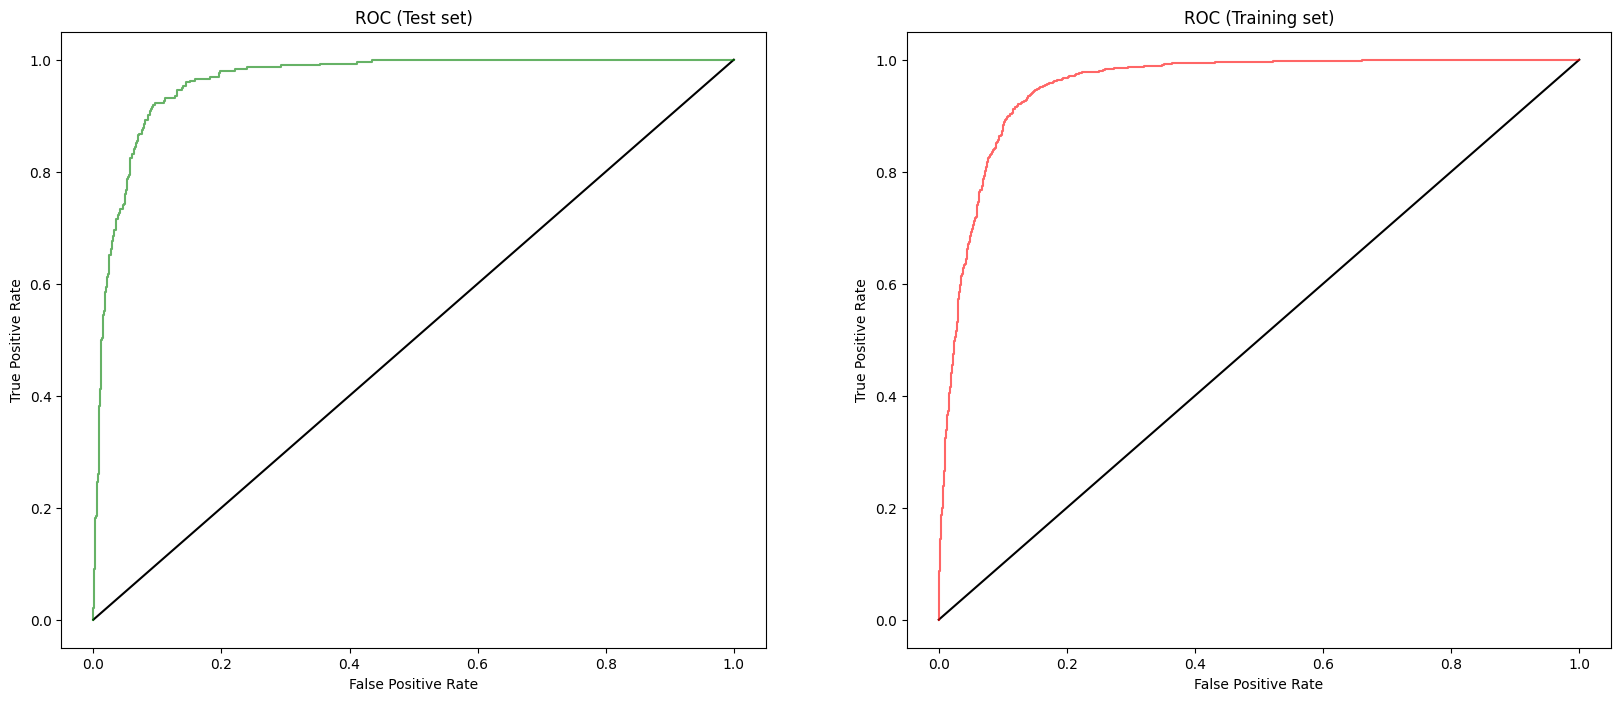

In [13]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

Processing fold 1...


C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_15296\2383922533.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


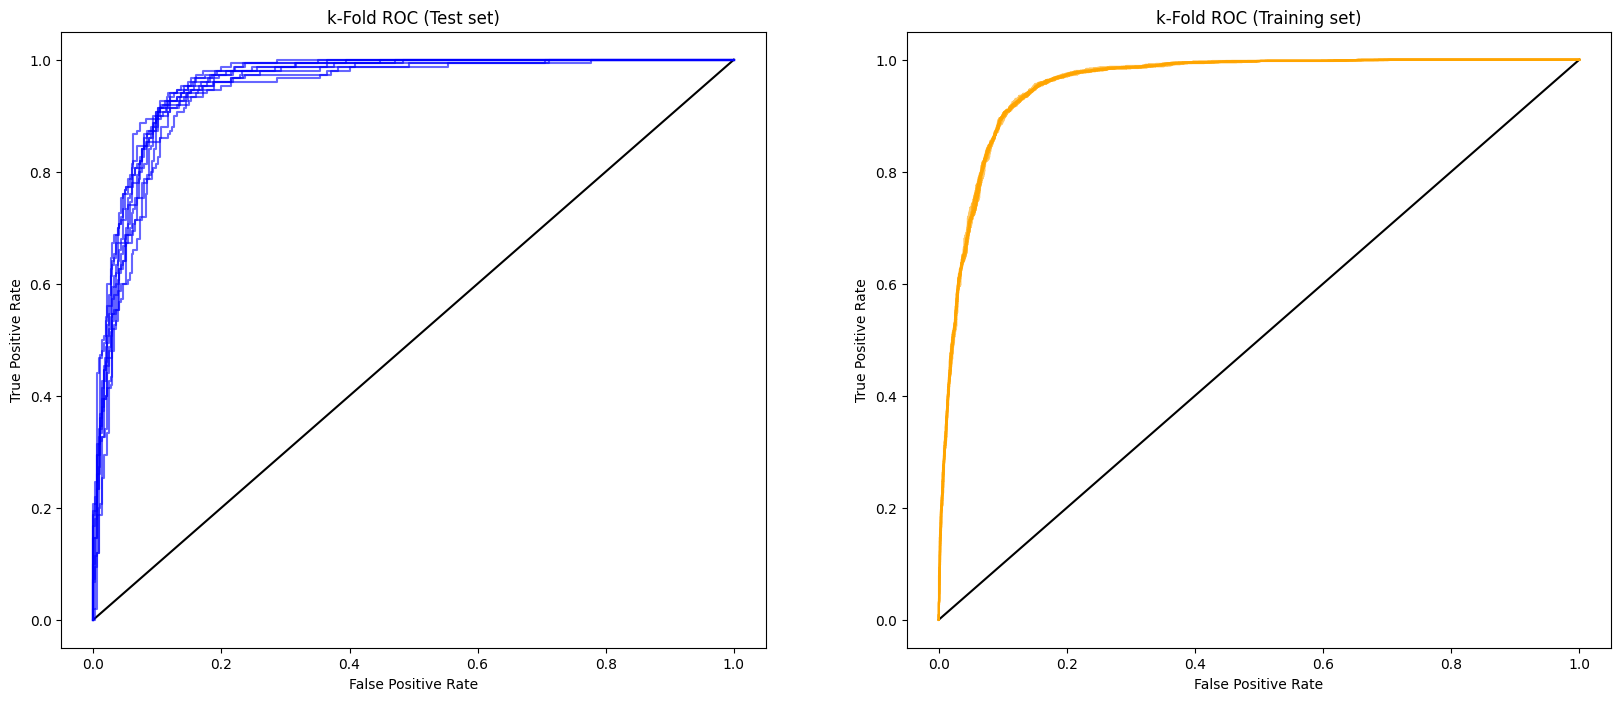

,Fold,ACC Test,ACC Training,ACC ratio,AUC Test,AUC Training,AUC ratio,CONF_MTX
0,0,0.882239,0.876880,1.006112,0.958750,0.956310,1.002552,"[[353, 15], [46, 104]]"
1,1,0.857143,0.876880,0.977492,0.947138,0.956488,0.990224,"[[343, 25], [49, 101]]"
2,2,0.878143,0.877551,1.000675,0.955441,0.955964,0.999453,"[[353, 14], [49, 101]]"
3,3,0.872340,0.877981,0.993576,0.957203,0.956294,1.000950,"[[350, 17], [49, 101]]"
4,4,0.880077,0.877551,1.002879,0.944850,0.957329,0.986965,"[[350, 17], [45, 105]]"
5,5,0.868472,0.879699,0.987237,0.953678,0.956669,0.996874,"[[349, 18], [50, 100]]"
6,6,0.889749,0.877766,1.013651,0.957439,0.956342,1.001147,"[[350, 17], [40, 110]]"
7,7,0.870406,0.877121,0.992344,0.957820,0.955909,1.002000,"[[350, 17], [50, 100]]"
8,8,0.878143,0.881418,0.996285,0.950917,0.957131,0.993508,"[[347, 20], [43, 107]]"
9,9,0.862669,0.877981,0.982561,0.945740,0.956945,0.988291,"[[348, 19], [52, 98]]"


In [14]:
lr_k_fold = k_fold_validation(logistic_regression, X_scaled, Y, plot_roc_curve=True)
lr_k_fold.head(10)

In [15]:
print_metrics(lr_metrics_train_and_test)

Train-Train AUC: 0.952991675662328
Train-Test AUC: 0.9637338624145119


Train-Train ACC: 0.8709209572153734
Train-Test ACC: 0.8859903381642512


Train-Train Confusion Matrix: 
 [[2798  135]
 [ 399  805]]


Train-Test Confusion Matrix: 
 [[717  22]
 [ 96 200]]


Train-Train Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2933
           1       0.86      0.67      0.75      1204

    accuracy                           0.87      4137
   macro avg       0.87      0.81      0.83      4137
weighted avg       0.87      0.87      0.87      4137



Train-Test Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       739
           1       0.90      0.68      0.77       296

    accuracy                           0.89      1035
   macro avg       0.89      0.82      0.85      1035
weighted avg       0.89      0.89      0.88      1035



Точността $ACC$ падна от Train-Test $ACC \approx 0.97$ на Train-Test $ACC \approx 0.88$

## 2. Random forest

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


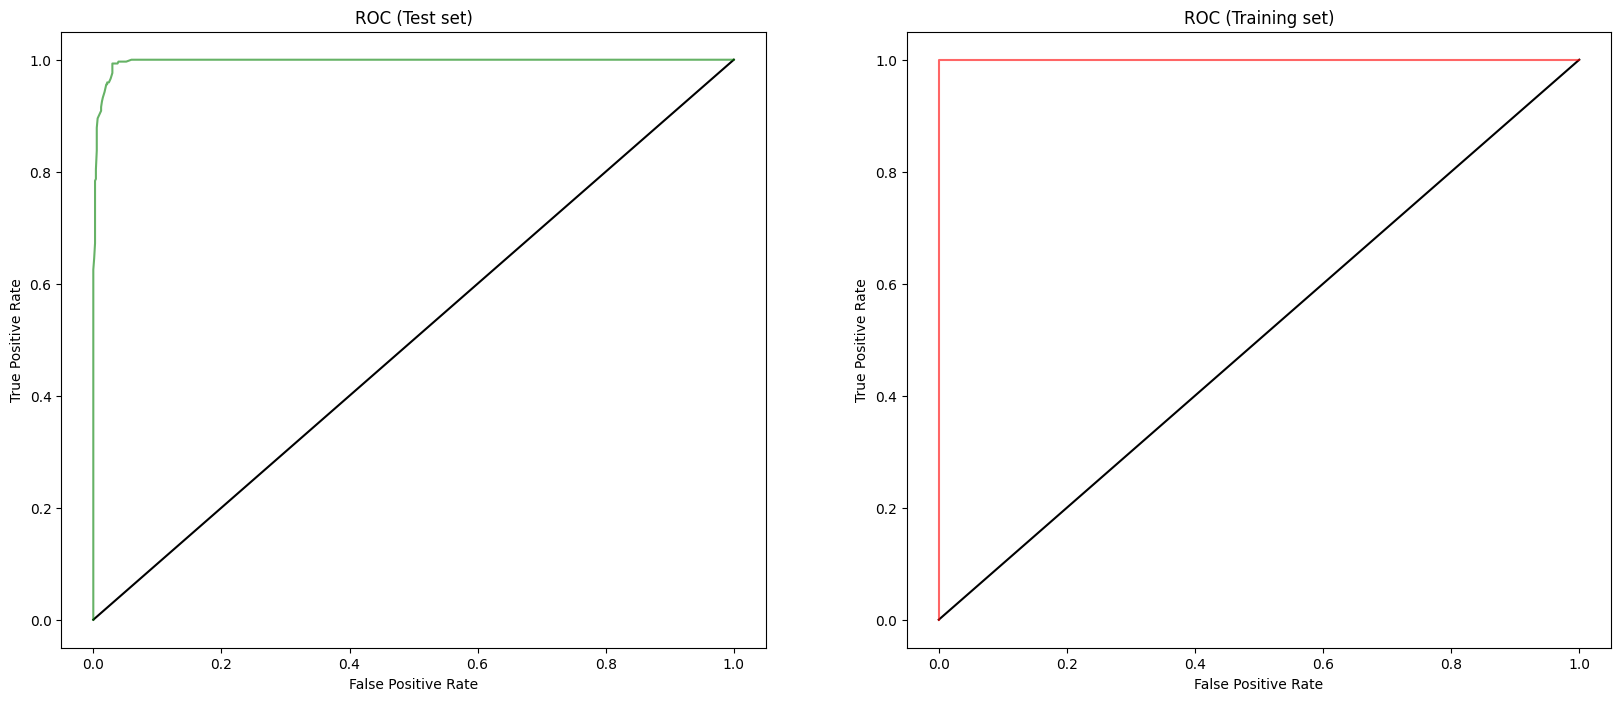

In [17]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

Processing fold 1...


C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_15296\2383922533.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...


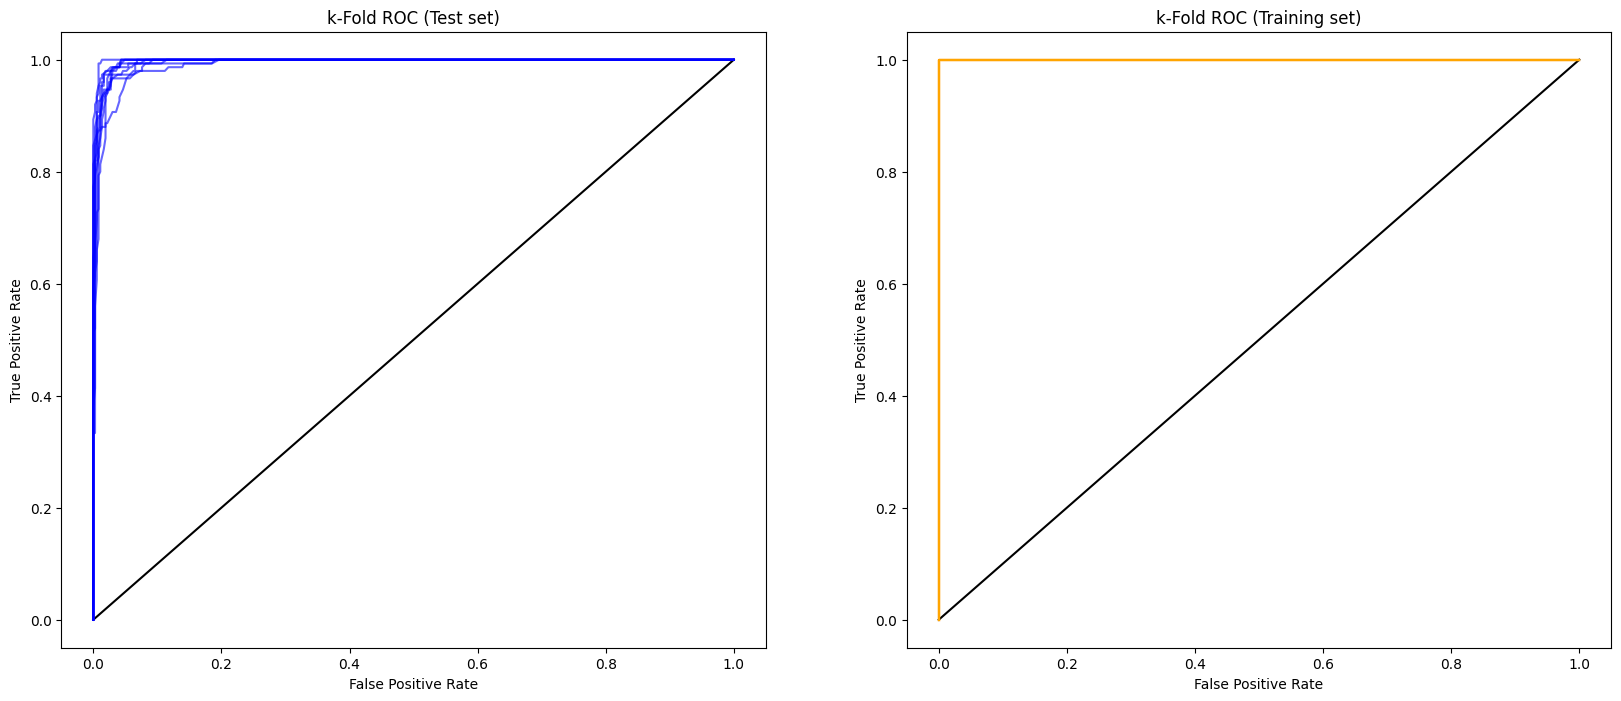

,Fold,ACC Test,ACC Training,ACC ratio,AUC Test,AUC Training,AUC ratio,CONF_MTX
0,0,0.980695,1.0,0.980695,0.997681,1.0,0.997681,"[[365, 3], [7, 143]]"
1,1,0.967181,1.0,0.967181,0.995127,1.0,0.995127,"[[359, 9], [8, 142]]"
2,2,0.974855,1.0,0.974855,0.993960,1.0,0.993960,"[[359, 8], [5, 145]]"
3,3,0.982592,1.0,0.982592,0.999319,1.0,0.999319,"[[364, 3], [6, 144]]"
4,4,0.949710,1.0,0.949710,0.992107,1.0,0.992107,"[[352, 15], [11, 139]]"
5,5,0.970986,1.0,0.970986,0.997511,1.0,0.997511,"[[362, 5], [10, 140]]"
6,6,0.970986,1.0,0.970986,0.995995,1.0,0.995995,"[[361, 6], [9, 141]]"
7,7,0.978723,1.0,0.978723,0.997275,1.0,0.997275,"[[362, 5], [6, 144]]"
8,8,0.969052,1.0,0.969052,0.995104,1.0,0.995104,"[[357, 10], [6, 144]]"
9,9,0.967118,1.0,0.967118,0.994151,1.0,0.994151,"[[358, 9], [8, 142]]"


In [18]:
rf_k_fold = k_fold_validation(random_forest, X, Y, plot_roc_curve=True)
rf_k_fold.head(10)

In [19]:
print_metrics(rf_metrics_train_and_test)

Train-Train AUC: 1.0
Train-Test AUC: 0.9968547708737153


Train-Train ACC: 1.0
Train-Test ACC: 0.9719806763285024


Train-Train Confusion Matrix: 
 [[2933    0]
 [   0 1204]]


Train-Test Confusion Matrix: 
 [[723  16]
 [ 13 283]]


Train-Train Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2933
           1       1.00      1.00      1.00      1204

    accuracy                           1.00      4137
   macro avg       1.00      1.00      1.00      4137
weighted avg       1.00      1.00      1.00      4137



Train-Test Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       739
           1       0.95      0.96      0.95       296

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



## 3. Neural network
Ще се наложи използването на `MinMaxScaller`

In [48]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


In [49]:
from keras import models, layers

NUMBER_INPUTS = X_train.shape[1]

network_layers = [layers.Input(shape = (NUMBER_INPUTS, )),
                  layers.Dense(50, activation = 'relu'),
                  layers.Dense(20, activation = 'relu'),
                  layers.Dense(10, activation = 'relu'),
                  layers.Dense(1, activation = 'sigmoid')]

neural_network = models.Sequential(network_layers)

neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 50)             │       150,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,291 (590.98 KB)

 Trainable params: 151,291 (590.98 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = neural_network.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7306 - loss: 0.5916 - val_accuracy: 0.8623 - val_loss: 0.3064
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9223 - loss: 0.2115 - val_accuracy: 0.9650 - val_loss: 0.1369
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0825 - val_accuracy: 0.9722 - val_loss: 0.0974
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 0.0422 - val_accuracy: 0.9734 - val_loss: 0.0879
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0277 - val_accuracy: 0.9771 - val_loss: 0.0871
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0234 - val_accuracy: 0.9771 - val_loss: 0.0899
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0161 - val_accuracy: 0.9783 - val_loss: 0.0946
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 0.9771 - val_loss

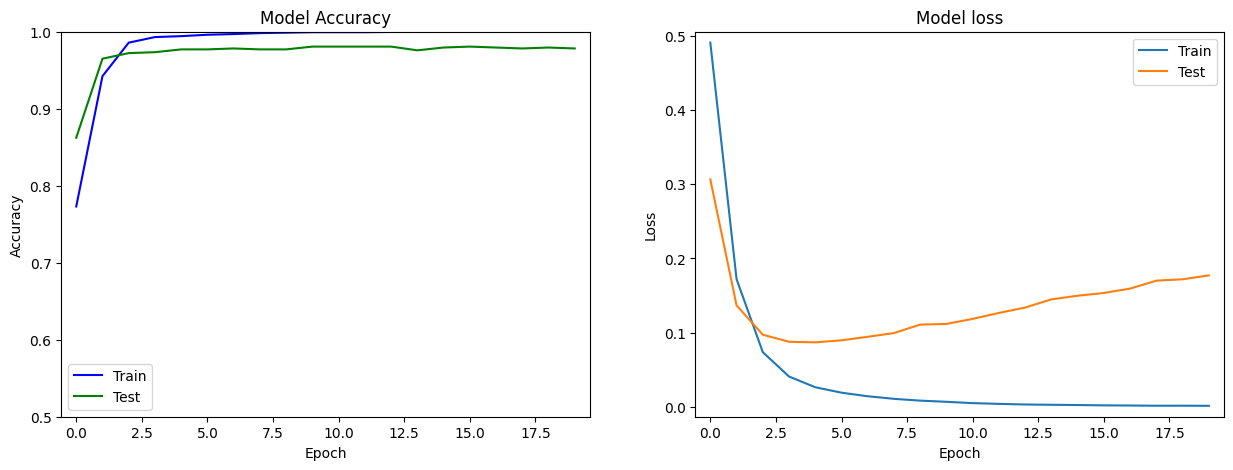

In [51]:
plot_history_nn(history)

Разклоняване около 10 тата епоха показва че невронната мрежа може да overfitне

In [41]:
network_layers_2 = [layers.Input(shape = (NUMBER_INPUTS, )),
                  layers.Dense(50, activation = 'relu'),
                  layers.Dense(50, activation = 'relu'),
                  layers.Dense(50, activation = 'relu'),
                  layers.Dense(1, activation = 'sigmoid')]

neural_network_2 = models.Sequential(network_layers_2)

neural_network_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 50)             │       150,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,201 (606.25 KB)

 Trainable params: 155,201 (606.25 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history_2 = neural_network_2.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7518 - loss: 0.4963 - val_accuracy: 0.9734 - val_loss: 0.1154
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0647 - val_accuracy: 0.9783 - val_loss: 0.0884
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9933 - loss: 0.0236 - val_accuracy: 0.9795 - val_loss: 0.0959
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0126 - val_accuracy: 0.9795 - val_loss: 0.1075
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0113 - val_accuracy: 0.9795 - val_loss: 0.1101
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 0.9795 - val_loss: 0.1214
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.9771 - val_loss: 0.1309
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0298 - val_accuracy: 0.

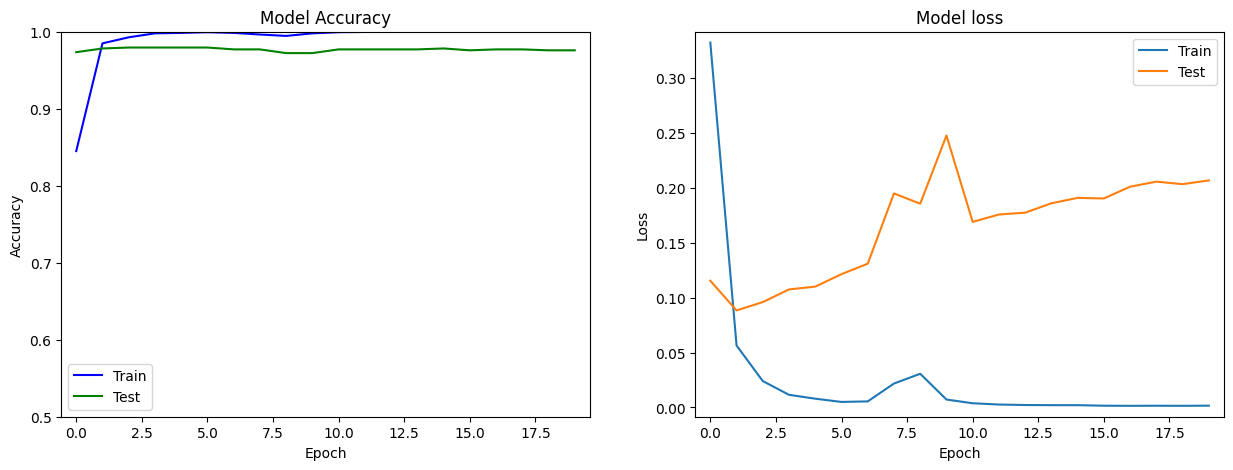

In [43]:
plot_history_nn(history_2)

Тази мрежа си overfit-ва още в началото на обучение

In [38]:
from keras import regularizers

network_layers_3 = [layers.Input(shape = (NUMBER_INPUTS, )),
                  layers.Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
                  layers.Dropout(0.3),
                  layers.Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
                  layers.Dropout(0.3),
                  layers.Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
                  layers.Dropout(0.3),
                  layers.Dense(1, activation = 'sigmoid')]

model_3 = models.Sequential(network_layers_3)

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 50)             │       150,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,201 (606.25 KB)

 Trainable params: 155,201 (606.25 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_3 = model_3.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6840 - loss: 1.7237 - val_accuracy: 0.8514 - val_loss: 0.7217
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8995 - loss: 0.6094 - val_accuracy: 0.9626 - val_loss: 0.4294
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.3922 - val_accuracy: 0.9529 - val_loss: 0.3564
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9604 - loss: 0.3303 - val_accuracy: 0.9710 - val_loss: 0.3354
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 0.3171 - val_accuracy: 0.9601 - val_loss: 0.3411
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9572 - loss: 0.3210 - val_accuracy: 0.9734 - val_loss: 0.3163
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9704 - loss: 0.2819 - val_accuracy: 0.9698 - val_loss: 0.3038
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9674 - loss: 0.2795 - val_accuracy: 0.

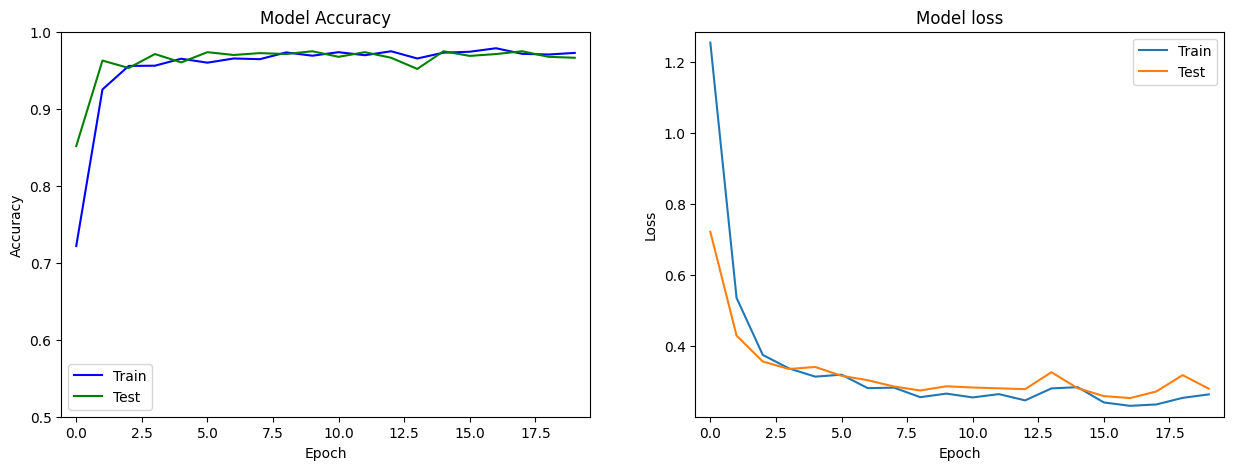

In [40]:
plot_history_nn(history_3)